## Machine Learning Prediction for in_playlist 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast 
import networkx as nx


from node2vec import Node2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Preprocessing 

### collab pre preprocessing

In [6]:


# Function to parse JSON column and extract key-value data
def parse_json_column(json_str):
    try:
        json_data = ast.literal_eval(json_str)
        if isinstance(json_data, dict):
            names = list(json_data.keys())
            counts = [item['count'] for item in json_data.values()]
            urls = [item['uri'] for item in json_data.values()]
            return pd.Series([names, counts, urls])
        else:
            return pd.Series([[], [], []])  # Empty lists for rows with invalid data
    except (ValueError, SyntaxError):
        return pd.Series([[], [], []])  # Handle parsing errors
    

#function to generate the unique number of collaborators, total published, and the highest collaborations count 
def get_collaboration_counts(df):
    # Get unique collaborators
    unique_collaborators = df['collab_names'].explode().unique()
    num_unique_collaborators = len(unique_collaborators)
    
    # Get total number of collaborations
    total_published = df['counts'].explode().sum()
    
    # Get highest collaboration count
    highest_collaboration_count = df['counts'].explode().max()
    
    return num_unique_collaborators, total_published, highest_collaboration_count



In [8]:
# read in week1.csv
week1 = pd.read_csv('week1.csv')
week2 = pd.read_csv('week2.csv')


#combine the two dataframes
week = pd.concat([week1, week2])
#week = week1

/var/folders/tn/pykrj5tn0bsf7t2j7wxnpqtw0000gn/T/ipykernel_58849/4203325173.py:4: DtypeWarning: Columns (2,3,6,7,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  week3 = pd.read_csv('week3.csv')


In [20]:
week3.isna().sum()

popularity                     0
followers                      0
in_playlist                    0
name                           0
collab_names                   0
num_collaborators              0
total_published                0
highest_collaboration_count    0
dtype: int64

In [9]:
week.columns


Index(['Unnamed: 0', 'source', 'genres', 'img_info', 'popularity', 'followers',
       'collaborators', 'in_playlist', 'link', 'name', 'api_link', 'pagerank',
       'closeness_cent', 'clustering', 'deg_cent', 'degree'],
      dtype='object')

In [11]:
# Apply parsing function to the column
week[['collab_names', 'counts', 'urls']] = week['collaborators'].apply(parse_json_column)
#get the counts 
week[['num_collaborators', 'total_published', 'highest_collaboration_count']] = get_collaboration_counts(week)

#drop the columns that are not needed
week = week.drop(columns=['Unnamed: 0', 'source', 'img_info', 'link', 'genres', 'api_link', 'collaborators',  'urls', 'counts','pagerank', 'closeness_cent', 'clustering', 'deg_cent', 'degree'])
#flattern the collab_names column
week = week.explode('collab_names')
week.head()

,popularity,followers,in_playlist,name,collab_names,num_collaborators,total_published,highest_collaboration_count
0,76,503600,True,Hanumankind,Hanumankind,39841,434055,50
0,76,503600,True,Hanumankind,Kalmi,39841,434055,50
0,76,503600,True,Hanumankind,Parimal Shais,39841,434055,50
0,76,503600,True,Hanumankind,Shalmali Kholgade,39841,434055,50
0,76,503600,True,Hanumankind,Vishal Dadlani,39841,434055,50


In [21]:
week.dtypes

popularity                      int64
followers                       int64
in_playlist                      bool
name                           object
collab_names                   object
num_collaborators               int64
total_published                 int64
highest_collaboration_count     int64
embedding                      object
dtype: object

## Graph prediction Label 

In [13]:
#drop rows that contain na
week = week.dropna()
#is na 
week.isna().sum()


popularity                     0
followers                      0
in_playlist                    0
name                           0
collab_names                   0
num_collaborators              0
total_published                0
highest_collaboration_count    0
dtype: int64

### Node embeddings


In [15]:
'''

Generate Node Embeddings:
1. Use adjacency matrix-based features or custom random walks to generate embeddings.
2. Aggregate node features and graph connections.
Train a Classifier:
3. Use these embeddings as features for classification.

'''
# Split the data into features and target
X_data = week.drop(columns = ['in_playlist'])
y_data = week['in_playlist']

# Create a graph from the dataframe
G = nx.from_pandas_edgelist(X_data, 'name', 'collab_names', edge_attr=True, create_using=nx.Graph())
# Generate the node embeddings
node2vec = Node2Vec(G, dimensions=50, walk_length=16, num_walks=100, workers=4)
model = node2vec.fit(window=7, min_count=1)
# Save embeddings for later use
model.wv.save_word2vec_format('node_embeddings.emb')




Computing transition probabilities:   0%|          | 0/39845 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:44<00:00,  1.76s/it]


In [16]:
from gensim.models.keyedvectors import KeyedVectors

# Custom loader for Word2Vec text files with node names containing spaces
def load_embeddings(file_path, vector_size):
    embeddings = {}
    with open(file_path, 'r') as f:
        next(f)  # Skip the header line
        for line in f:
            parts = line.strip().split()
            node_name = " ".join(parts[:-vector_size])  # Combine all but the last `vector_size` parts for the name
            vector = list(map(float, parts[-vector_size:]))  # Convert last `vector_size` parts to floats
            embeddings[node_name] = vector
    return embeddings

# Load embeddings
file_path = 'node_embeddings.emb'
vector_size = 50  # Dimensionality of embeddings
embeddings = load_embeddings(file_path, vector_size)

# Convert to a KeyedVectors-like object for compatibility
from gensim.models.keyedvectors import KeyedVectors
model = KeyedVectors(vector_size=vector_size)
model.add_vectors(list(embeddings.keys()), list(embeddings.values()))


In [17]:
# Example: Retrieve embeddings for a node
node_name = "Various Artists"
embedding = model[node_name] if node_name in model else [0] * vector_size
print(f"Embedding for {node_name}: {embedding}")


Embedding for Various Artists: [ 0.14718673  0.44656673  0.37467325 -0.05478834 -0.14934392 -0.17648016
 -0.18584932  0.3411636  -0.3782035   0.05534828 -0.0790932  -0.5002968
 -0.12043397  0.0294015  -0.11905624 -0.01192137  0.34175926  0.00118823
 -0.47264662 -0.31012368  0.25827244  0.22035709  0.36639935 -0.15738823
 -0.0253698  -0.21669449  0.29515952  0.02042306 -0.652161   -0.05858913
  0.3486502   0.26014748  0.00174195 -0.3442192   0.17053877 -0.01445311
  0.04339943  0.01838707 -0.34570235 -0.26450962 -0.46061635  0.09604499
  0.02295916 -0.34689733  0.30609372 -0.49824437 -0.41253808  0.18207218
 -0.01451882  0.3972947 ]


In [18]:


# Replace `name` with embeddings
def get_embedding(node_name, model, vector_size):
    if node_name in model:
        return model[node_name]
    else:
        return [0] * vector_size  # Default embedding for missing nodes

vector_size = 50  # Set this to match your embeddings
week['embedding'] = week['name'].apply(lambda x: get_embedding(x, model, vector_size))

#Prepare feature matrix (X) and target vector (y)
X = np.vstack(week['embedding'].values)  # Stack embeddings into a 2D array
y = week['in_playlist'].astype(int)      # Convert to numeric labels (1 or 0)

#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [22]:
# Define models for evaluation
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Support Vector Machine': SVC(random_state=42),

}

# Evaluate models
best_model = None
best_f1 = 0

for name, model in models.items():
    #train the model
    model.fit(X_train, y_train)
    #make predictions
    y_pred = model.predict(X_test)
    #evaluate the model with accuracy, precision, recall, and f1
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print("*" * 40)

    # Keep track of the best model
    if f1 > best_f1:
        best_f1 = f1
        best_model = model


#save the best model
import joblib
joblib.dump(best_model, 'best_model.pkl')
print("Best model saved to best_model.pkl with F1 score:", best_f1)

Random Forest:
  Accuracy: 0.9989
  Precision: 0.9916
  Recall: 0.9722
  F1 Score: 0.9818
****************************************
Gradient Boosting:
  Accuracy: 0.9878
  Precision: 1.0000
  Recall: 0.5907
  F1 Score: 0.7427
****************************************
Logistic Regression:
  Accuracy: 0.9698
  Precision: 0.3881
  Recall: 0.0268
  F1 Score: 0.0501
****************************************
Support Vector Machine:
  Accuracy: 0.9972
  Precision: 0.9856
  Recall: 0.9186
  F1 Score: 0.9509
****************************************
Best model saved to best_model.pkl with F1 score: 0.9817803227485684


In [23]:
# 5 fold cross validation and show the average F1 score for each model 

for name, model in models.items():
    f1_scores = cross_val_score(model, X, y, cv=5, scoring='f1')
    print(f"{name} - F1 Scores: {f1_scores}")
    print(f"Average F1 Score: {f1_scores.mean()}")
    print("*" * 40)





Random Forest - F1 Scores: [0.98698699 0.9897541  0.93109061 0.95307209 1.        ]
Average F1 Score: 0.9721807567251929
****************************************
Gradient Boosting - F1 Scores: [0.53049229 0.40839387 0.45412844 0.47976879 0.32625319]
Average F1 Score: 0.43980731273317836
****************************************
Logistic Regression - F1 Scores: [0.09023669 0.07314726 0.         0.         0.0742913 ]
Average F1 Score: 0.04753504869322952
****************************************
Support Vector Machine - F1 Scores: [0.91973751 0.95716552 0.84251969 0.92522433 0.92876563]
Average F1 Score: 0.9146825345506283
****************************************


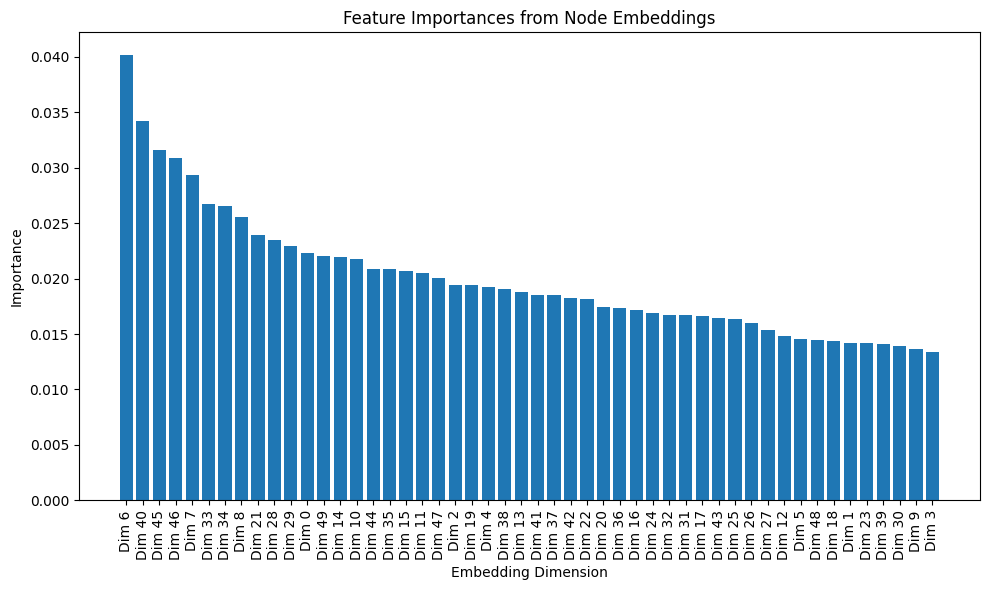

In [24]:
importances = best_model.feature_importances_
# Create a bar chart for feature importances
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances from Node Embeddings")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), [f"Dim {i}" for i in indices], rotation=90)
plt.xlabel("Embedding Dimension")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

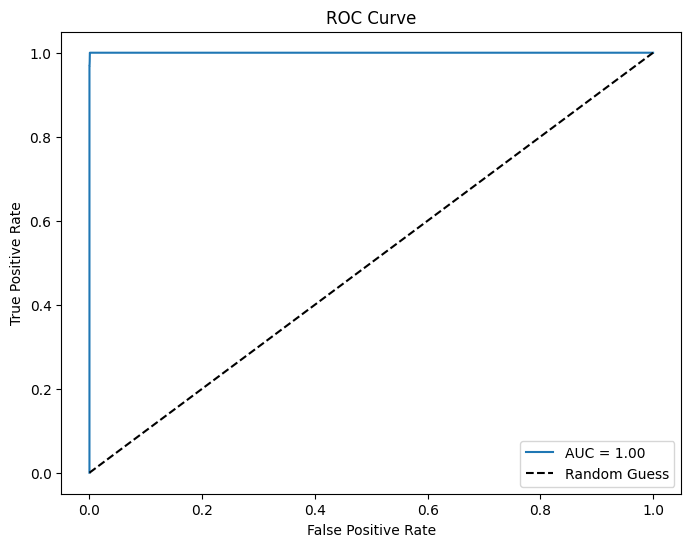

In [25]:
from sklearn.metrics import roc_curve, auc

# Get probabilities for the positive class
y_prob = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
